In [1]:
# Install necessary packages
#!pip install cupy-cuda12x 

# Import libraries
import pandas as pd
import numpy as np
import random
from surprise import Reader, Dataset, SVD, SVDpp, NMF, accuracy, Prediction, AlgoBase, SlopeOne, KNNBasic
from surprise.model_selection import train_test_split, cross_validate, KFold
import torch
from tqdm.notebook import tqdm
from surprise import SVD, SVDpp, NMF, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pickle
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import warnings  # Added this line

# Set random seed for reproducibility
my_seed = 1234
random.seed(my_seed)
np.random.seed(my_seed)

# Load the ratings data
ratings_df = pd.read_csv('data/rating.csv')

In [2]:
# Remove -1 values (implicit feedback) to focus on explicit feedback only
ratings_df = ratings_df[ratings_df['rating'] != -1]

In [3]:
# Randomly pick 5% of users
all_users = ratings_df['user_id'].unique()
sample_size = int(0.05 * len(all_users))
sampled_users = np.random.choice(all_users, size=sample_size, replace=False)

# Filter ratings to keep only the sampled users
ratings_sampled = ratings_df[ratings_df['user_id'].isin(sampled_users)]

# Further sample data for efficiency if needed
ratings_filtered_sample = ratings_sampled.sample(n=35000, random_state=my_seed)

In [4]:
# Define the scale of ratings
min_rating = ratings_sampled['rating'].min()
max_rating = ratings_sampled['rating'].max()

# Create a Surprise Reader object
reader = Reader(rating_scale=(min_rating, max_rating))

# Load the data into Surprise format
anime_data = Dataset.load_from_df(ratings_sampled[['user_id', 'anime_id', 'rating']], reader)

In [5]:
# Split into training and testing sets (80% train, 20% test)
trainset, testset = train_test_split(anime_data, test_size=.20, random_state=my_seed)

# Baseline

In [6]:
# Global Mean Baseline
class GlobalMeanBaseline(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)
    
    def estimate(self, u, i):
        return self.trainset.global_mean
    
    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        return self

# Popular Items Baseline (already implemented in the RecSys project)
class PopularBaseline(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)
    
    def estimate(self, u, i):
        if i in self.mean_rating_per_item_df.index:
            return self.mean_rating_per_item_df.loc[i]['rating']
        else:
            return self.trainset.global_mean
    
    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        
        ratings_df = pd.DataFrame([[i, r] for (_, i, r) in self.trainset.all_ratings()],
                                  columns=['item', 'rating'])
        
        self.mean_rating_per_item_df = (ratings_df
          .groupby('item')
          .agg({'rating': 'mean'})
        )
        
        return self

In [7]:
# Create baseline models
global_mean_baseline = GlobalMeanBaseline()
popular_baseline = PopularBaseline()

# Train the baseline models
global_mean_baseline.fit(trainset)
popular_baseline.fit(trainset)

# Make predictions
global_predictions = global_mean_baseline.test(testset)
popular_predictions = popular_baseline.test(testset)

# Evaluate baseline performance
print("Global Mean Baseline RMSE:", accuracy.rmse(global_predictions))
print("Popular Items Baseline RMSE:", accuracy.rmse(popular_predictions))

RMSE: 1.5522
Global Mean Baseline RMSE: 1.5521792341520126
RMSE: 1.4388
Popular Items Baseline RMSE: 1.4388169704620213


# Ensamble Model

In [8]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")
if cuda_available:
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print("Using CPU instead")

CUDA Available: True
GPU Device: NVIDIA GeForce RTX 4090


In [9]:
# Define a function to create base models
def create_base_models(random_state=my_seed):
    models = {
        # Model-based CF approaches
        'SVD': SVD(random_state=random_state),
        'SVDpp': SVDpp(random_state=random_state),
        'NMF': NMF(random_state=random_state),
        
        # Memory-based CF approaches
        'KNN_Basic': KNNBasic(sim_options={'name': 'cosine', 'user_based': False}),
        'KNN_Means': KNNWithMeans(sim_options={'name': 'pearson', 'user_based': False}),
        'KNN_ZScore': KNNWithZScore(sim_options={'name': 'pearson', 'user_based': False}),
        
        # User-based approaches
        'User_KNN_Basic': KNNBasic(sim_options={'name': 'cosine', 'user_based': True}),
        'User_KNN_Means': KNNWithMeans(sim_options={'name': 'pearson', 'user_based': True})
    }
    return models

# Create base models
base_models = create_base_models()

In [10]:
# Function to train models and get predictions
def train_and_predict(models, trainset, testset):
    all_predictions = {}
    all_models = {}
    
    for name, model in tqdm(models.items(), desc="Training Models"):
        # Train the model
        start_time = time.time()
        model.fit(trainset)
        train_time = time.time() - start_time
        
        # Make predictions
        start_time = time.time()
        predictions = model.test(testset)
        predict_time = time.time() - start_time
        
        # Store predictions and trained model
        all_predictions[name] = predictions
        all_models[name] = model
        
        # Calculate RMSE
        rmse = accuracy.rmse(predictions)
        print(f"{name}: RMSE = {rmse:.4f}, Train Time = {train_time:.2f}s, Predict Time = {predict_time:.2f}s")
    
    return all_predictions, all_models

# Train models and get predictions
print("Training base models and collecting predictions...")
all_predictions, all_models = train_and_predict(base_models, trainset, testset)

Training base models and collecting predictions...


Training Models:   0%|          | 0/8 [00:00<?, ?it/s]

RMSE: 1.1970
SVD: RMSE = 1.1970, Train Time = 2.64s, Predict Time = 0.53s
RMSE: 1.1986
SVDpp: RMSE = 1.1986, Train Time = 237.10s, Predict Time = 18.94s
RMSE: 2.2201
NMF: RMSE = 2.2201, Train Time = 5.66s, Predict Time = 0.55s
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3654
KNN_Basic: RMSE = 1.3654, Train Time = 5.20s, Predict Time = 12.91s
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2301
KNN_Means: RMSE = 1.2301, Train Time = 6.72s, Predict Time = 13.78s
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2309
KNN_ZScore: RMSE = 1.2309, Train Time = 7.01s, Predict Time = 13.85s
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.4359
User_KNN_Basic: RMSE = 1.4359, Train Time = 3.67s, Predict Time = 12.26s
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2218
User_KNN_Means: RMSE = 1.2218, Train Time = 4.6

In [11]:
# Create a meta-dataset for stacking
def create_meta_dataset(all_predictions, testset):
    # Create a dictionary to store all predictions
    meta_data = {}
    
    # Organize predictions by user-item pair
    for model_name, predictions in all_predictions.items():
        for pred in predictions:
            user = pred.uid
            item = pred.iid
            rating = pred.r_ui
            estimated = pred.est
            
            # Create keys for each user-item pair
            key = (user, item)
            
            if key not in meta_data:
                meta_data[key] = {
                    'actual': rating,
                    'predictions': {}
                }
            
            # Add this model's prediction
            meta_data[key]['predictions'][model_name] = estimated
    
    # Convert to DataFrame
    rows = []
    for key, data in meta_data.items():
        row = {'user': key[0], 'item': key[1], 'actual': data['actual']}
        row.update(data['predictions'])
        rows.append(row)
    
    meta_df = pd.DataFrame(rows)
    return meta_df

# Create meta dataset
print("Creating meta-dataset for stacking...")
meta_df = create_meta_dataset(all_predictions, testset)
print(f"Meta-dataset shape: {meta_df.shape}")
meta_df.head()

Creating meta-dataset for stacking...
Meta-dataset shape: (64602, 11)


,user,item,actual,SVD,SVDpp,NMF,KNN_Basic,KNN_Means,KNN_ZScore,User_KNN_Basic,User_KNN_Means
0,57662,225,10.0,7.663576,8.774269,6.364171,8.046684,7.635886,7.788609,7.425114,7.194170
1,25928,3455,6.0,7.578248,7.335597,5.863711,8.398509,7.902761,7.955644,7.200902,7.370286
2,14445,3702,8.0,6.470841,6.506500,4.641915,5.889604,5.854128,5.648326,8.750435,6.602672
3,11483,3091,10.0,9.747190,9.686937,8.146973,9.303771,9.821812,9.749918,8.674906,9.926645
4,21786,8525,9.0,9.174973,8.362307,6.476377,8.449149,8.663591,8.651908,8.850686,8.850351


In [12]:
# Create training data for meta-model
X = meta_df.drop(['user', 'item', 'actual'], axis=1)
y = meta_df['actual']

# Split into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=my_seed)

# Define meta-models
meta_models = {
    'Simple_Average': None,  # We'll implement this differently
    'Weighted_Average': None,  # We'll implement this differently
    'Linear_Regression': LinearRegression(),
    'Ridge_Regression': Ridge(alpha=1.0),
    'Random_Forest': RandomForestRegressor(
        n_estimators=100, max_depth=10, random_state=my_seed,
        n_jobs=-1 if not cuda_available else 1  # Use all CPU cores if GPU not available
    ),
    'Gradient_Boosting': GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, random_state=my_seed
    )
}

# Train and evaluate meta-models
meta_results = {}

print("Training meta-models...")
for name, model in tqdm(meta_models.items(), desc="Training Meta-Models"):
    if name == 'Simple_Average':
        # Simple average prediction
        preds = X_val.mean(axis=1)
        meta_results[name] = {
            'model': None,
            'predictions': preds,
            'rmse': np.sqrt(mean_squared_error(y_val, preds))
        }
    
    elif name == 'Weighted_Average':
        # Weighted average based on individual model RMSE
        weights = {}
        for model_name in base_models.keys():
            model_preds = [p.est for p in all_predictions[model_name]]
            model_actual = [p.r_ui for p in all_predictions[model_name]]
            rmse = np.sqrt(np.mean((np.array(model_actual) - np.array(model_preds)) ** 2))
            # Inverse weighting - lower RMSE gets higher weight
            weights[model_name] = 1 / rmse
        
        # Normalize weights
        total = sum(weights.values())
        weights = {k: v / total for k, v in weights.items()}
        
        # Apply weights
        weighted_preds = np.zeros(len(X_val))
        for model_name, weight in weights.items():
            weighted_preds += X_val[model_name].values * weight
        
        meta_results[name] = {
            'model': weights,
            'predictions': weighted_preds,
            'rmse': np.sqrt(mean_squared_error(y_val, weighted_preds))
        }
    
    else:
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        preds = model.predict(X_val)
        
        # Store results
        meta_results[name] = {
            'model': model,
            'predictions': preds,
            'rmse': np.sqrt(mean_squared_error(y_val, preds))
        }
    
    print(f"{name}: RMSE = {meta_results[name]['rmse']:.4f}")

Training meta-models...


Training Meta-Models:   0%|          | 0/6 [00:00<?, ?it/s]

Simple_Average: RMSE = 1.2180
Weighted_Average: RMSE = 1.2029
Linear_Regression: RMSE = 1.1716
Ridge_Regression: RMSE = 1.1716
Random_Forest: RMSE = 1.1737
Gradient_Boosting: RMSE = 1.1698


In [13]:
if cuda_available:
    print("Building GPU-accelerated ensemble...")
    
    # Define a simple neural network meta-model
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
    
    class EnsembleNet(nn.Module):
        def __init__(self, input_size):
            super(EnsembleNet, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(input_size, 64),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, 1)
            )
        
        def forward(self, x):
            return self.layers(x)
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1).to(device)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1).to(device)
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    
    # Initialize model
    input_size = X_train.shape[1]
    model = EnsembleNet(input_size).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    epochs = 50
    for epoch in tqdm(range(epochs), desc="Training NN Ensemble"):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            
            # Convert back to CPU for RMSE calculation
            val_preds = val_outputs.cpu().numpy().flatten()
            val_actual = y_val_tensor.cpu().numpy().flatten()
            val_rmse = np.sqrt(mean_squared_error(val_actual, val_preds))
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}: Loss = {val_loss:.4f}, RMSE = {val_rmse:.4f}")
    
    # Add NN results to meta_results
    meta_results['Neural_Network'] = {
        'model': model,
        'predictions': val_preds,
        'rmse': val_rmse
    }

Building GPU-accelerated ensemble...


Training NN Ensemble:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50: Loss = 1.8355, RMSE = 1.3548
Epoch 20/50: Loss = 1.4302, RMSE = 1.1959
Epoch 30/50: Loss = 1.5565, RMSE = 1.2476
Epoch 40/50: Loss = 1.4169, RMSE = 1.1903
Epoch 50/50: Loss = 1.4109, RMSE = 1.1878


In [14]:
# Add this line before the function definition
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.utils.validation')

# Function to generate final predictions
def generate_final_predictions(testset, base_models, meta_model_name, meta_models, meta_results):
    print(f"Generating final predictions using {meta_model_name}...")
    
    # Get the selected meta-model
    meta_model = meta_results[meta_model_name]['model']
    
    # Store final predictions
    final_predictions = []
    
    # Get feature names from base models
    feature_names = list(base_models.keys())
    
    for uid, iid, r_ui in tqdm(testset, desc="Generating Final Predictions"):
        # Collect predictions from all base models
        base_preds = {}
        for name, model in base_models.items():
            pred = model.predict(uid, iid)
            base_preds[name] = pred.est
        
        # Make final prediction based on meta-model type
        if meta_model_name == 'Simple_Average':
            final_est = sum(base_preds.values()) / len(base_preds)
        elif meta_model_name == 'Weighted_Average':
            final_est = sum(base_preds[name] * weight for name, weight in meta_model.items())
        elif meta_model_name == 'Neural_Network':
            X_test = torch.tensor([list(base_preds.values())], dtype=torch.float32).to(device)
            with torch.no_grad():
                final_est = meta_model(X_test).cpu().numpy()[0][0]
        else:
            # Create DataFrame with proper feature names instead of NumPy array
            X_test = pd.DataFrame([list(base_preds.values())], columns=feature_names)
            final_est = meta_model.predict(X_test)[0]
        
        # Ensure prediction is within rating scale
        final_est = max(min(final_est, max_rating), min_rating)
        
        # Create prediction object
        final_predictions.append(Prediction(uid, iid, r_ui, final_est, {}))
    
    return final_predictions


# Select best meta-model based on validation RMSE
best_meta_model = min(meta_results.items(), key=lambda x: x[1]['rmse'])[0]
print(f"Best meta-model: {best_meta_model} with RMSE = {meta_results[best_meta_model]['rmse']:.4f}")

# Generate final predictions
final_predictions = generate_final_predictions(
    testset, all_models, best_meta_model, meta_models, meta_results
)

# Calculate final RMSE
final_rmse = accuracy.rmse(final_predictions)
print(f"Final Ensemble RMSE: {final_rmse:.4f}")

Best meta-model: Gradient_Boosting with RMSE = 1.1698
Generating final predictions using Gradient_Boosting...


Generating Final Predictions:   0%|          | 0/64602 [00:00<?, ?it/s]

RMSE: 1.1478
Final Ensemble RMSE: 1.1478


RMSE: 1.1970
RMSE: 1.1986
RMSE: 2.2201
RMSE: 1.3654
RMSE: 1.2301
RMSE: 1.2309
RMSE: 1.4359
RMSE: 1.2218
RMSE: 1.1478


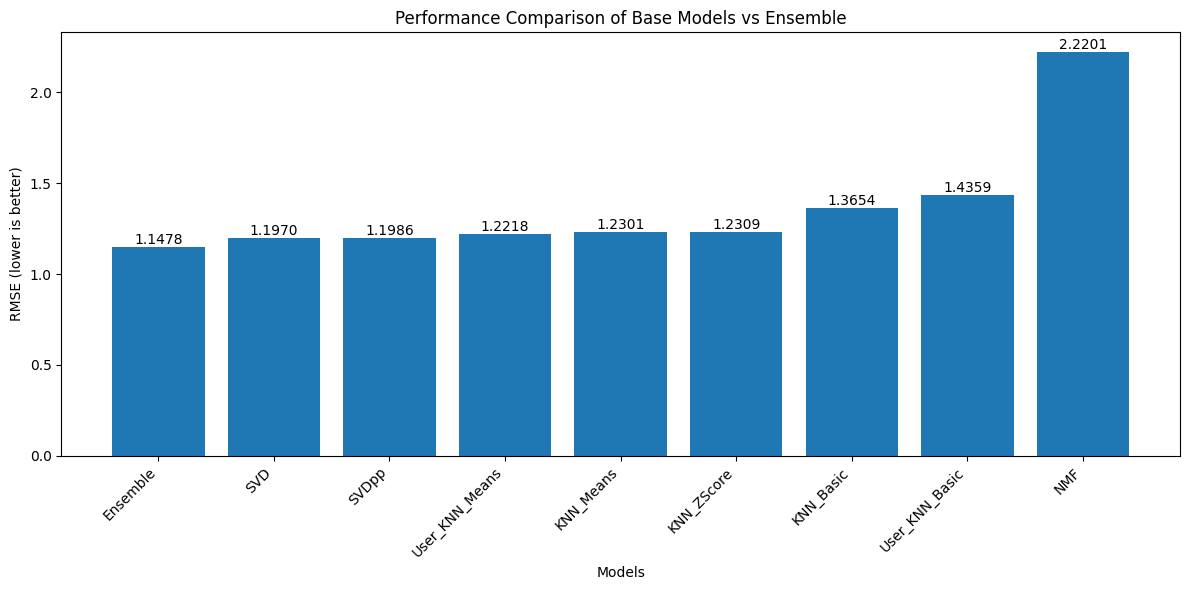

In [15]:
# Compare performance of individual models and ensemble
def plot_model_comparison(all_predictions, final_predictions):
    model_rmse = {}
    for name, predictions in all_predictions.items():
        model_rmse[name] = accuracy.rmse(predictions)
    
    # Add ensemble
    model_rmse['Ensemble'] = accuracy.rmse(final_predictions)
    
    # Sort by RMSE
    model_rmse = {k: v for k, v in sorted(model_rmse.items(), key=lambda item: item[1])}
    
    # Plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_rmse.keys(), model_rmse.values())
    plt.xlabel('Models')
    plt.ylabel('RMSE (lower is better)')
    plt.title('Performance Comparison of Base Models vs Ensemble')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', rotation=0)
    
    plt.tight_layout()
    plt.show()

# Plot model comparison
plot_model_comparison(all_predictions, final_predictions)

In [16]:
# Save the trained models for future use
def save_models(base_models, meta_model_name, meta_results):
    print("Saving trained models...")
    
    # Create models directory if it doesn't exist
    import os
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Save base models
    for name, model in base_models.items():
        with open(f'models/{name}_model.pkl', 'wb') as f:
            pickle.dump(model, f)
    
    # Save meta model
    meta_model = meta_results[meta_model_name]['model']
    if meta_model_name != 'Neural_Network':
        with open(f'models/meta_{meta_model_name}_model.pkl', 'wb') as f:
            pickle.dump(meta_model, f)
    else:
        # For PyTorch model, save state dict
        torch.save(meta_model.state_dict(), f'models/meta_{meta_model_name}_model.pt')
    
    print("Models saved successfully!")

# Save models
save_models(all_models, best_meta_model, meta_results)

Saving trained models...
Models saved successfully!
